This notebook will walk you through how to make a converted FGS raw image from a FGS point source uncal image from MIRAGE. These images have PSFs for all stars in the field of view, but do not have detector effects, and have not been clipped for saturation. These images are in units of ADU/second and are therefore ready to go in MAGIC> 

These images can be used on the FGSES for OTB runs in conjunction with the override file created from a NIRCam image. 

In [26]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import jwst_magic
from jwst_magic.convert_image.convert_image_to_raw_fgs import OUT_PATH, remove_pedestal, correct_nircam_dq, transform_nircam_image, resize_nircam_image, transform_sci_to_fgs_raw, apply_coarse_pointing_filter, create_seed_image, normalize_data, create_all_found_psfs_file, save_all_found_psfs_file, write_fgs_im
from jwst_magic.convert_image import renormalize
from jwst_magic.utils import utils

%matplotlib inline

In [23]:
data_location = '/ifs/jwst/wit/fgs/rehearsals/OTE-07/2021_03_sir3/images/for_obs1'

nircam_data_filename = os.path.join(data_location, 'jw00646014001_01101_00001_nrca3_cal.fits') # NIRCam image from last observation
nircam_image = fits.getdata(nircam_data_filename)

fgs_data_filename = os.path.join(data_location, 'jw00646015001_01101_00001_g1_uncal_ptsrc_seed_image.fits') # FGS image from the future
fgs_image = fits.getdata(fgs_data_filename)

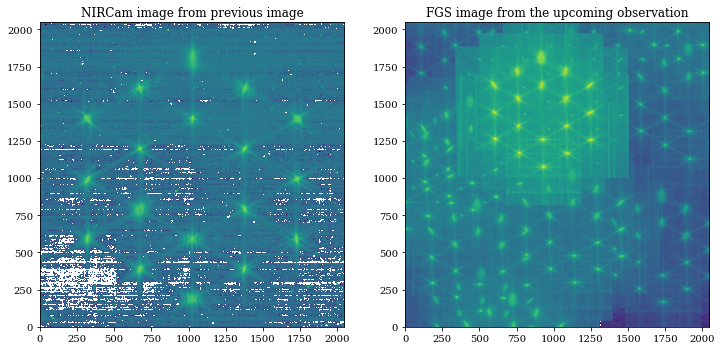

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

ax[0].imshow(nircam_image, origin='lower', norm=LogNorm())
ax[0].set_title('NIRCam image from previous image')

ax[1].imshow(fgs_image, origin='lower', norm=LogNorm())
ax[1].set_title('FGS seed image from the upcoming observation')

plt.show()

In MAGIC, run the NIRCam image through the full process, using Add Background stars to get the expected background stars. This will follow the normal process. These will be your "commanded" values.

In order to get the best corresponding FGS images that will be put on the FGSES and that the NIRCam generated numbers will be applied to. These will be your "actual" images.

**Below, check the ratio of the count rates in this image compared to the catalog count rates:**

## Set your variables for this observation

In [20]:
# This function is taken directly from MAGIC, removing the part that creates a seed image
# Renormalization here will be different -- find and use a scaling factor for the full image
# All Logger functions have been removed since they will not work here

def convert_im(input_im, guider, root, out_dir=None, nircam=True,
               nircam_det=None, normalize=True, norm_value=12.0,
               norm_unit="FGS Magnitude", smoothing='default',
               psf_size=None, all_found_psfs_file=None, gs_catalog=None,
               coarse_pointing=False, jitter_rate_arcsec=None,
               itm=False, multiply_by_count_rate_factor=False):
    """Takes NIRCam or FGS image and converts it into an FGS-like image.

    Parameters
    ----------
    input_im : str
        Filepath for the input (NIRCam or FGS) image
    guider : int
        Guider number (1 or 2)
    root : str
        Name used to create the output directory, {out_dir}/out/{root}
    out_dir : str, optional
        Where output files will be saved. If not provided, the
        image(s) will be saved within the repository at
        jwst_magic/. This path is the level outside the out/root/ dir
    nircam : bool, optional
        Denotes if the input_image is an FGS or NIRCam image. If True,
        the image will be converted to FGS format. Unless out_dir is
        specified, the FGS-formatted image will be saved to
        ../out/{root}/FGS_imgs/{root}_binned_pad_norm.fits
    nircam_det : str, optional
        The detector of a provided NIRCam image. If left blank, the
        detector will be extracted from the header of the NIRCam FITS
        file.
    normalize : bool, optional
        Denotes if the image will be normalized. If True, norm_value
        and norm_unit will be used to determine the normalization value
    norm_value : str or float, optional
        Specifies the Guide Star ID or the count rate/magnitude to which
        to normalize.
    norm_unit : str, optional
        Specifies the unit of norm_value ("FGS Magnitude", "FGS countrate",
        or "Guide Star ID")
    smoothing: str, optional
        Options are "low" for minimal smoothing (e.g. MIMF), "high" for large
        smoothing (e.g. GA), "default" for medium smoothing for other cases,
        or "choose center" for finding the center of a MIMF PSF
    psf_size: int, optional
        Set the size of the stamps to use when cutting out PSFs from the image.
        Input is the edge of the square size in pixels (e.g. if 100, the stamp
        will be 100px x 100px). If not set, default values will be used based
        on smoothing choice.
    all_found_psfs_file: str, optional
        A pre-made all_found_psfs file to use when creating the pseudo-FGS
        image rather than making a new one in the code. This can be used
        when MAGIC's current smoothing methods aren't sufficient in
        blocking background segments and PSFs need to be deleted from the
        MAGIC-made all found PSFs file in the backend.
    gs_catalog : str, optional
        Guide star catalog version to query. E.g. 'GSC242'. None will use
        the default catalog as defined in teh FGS Count Rate Module.
    coarse_pointing : bool, optional
        Denotes if the image will have a Gaussian filter applied to
        simulate the effects of jitter when the observatory is in
        coarse pointing rather than fine guide.
    jitter_rate_arcsec : None, optional
        The rate of the spacecraft jitter, in arcseconds per second,
        that will be used to apply the Gaussian filter if
        coarse_pointing is True.
    itm : bool, optional
        If this image come from the ITM simulator (important for normalization).
    multiply_by_count_rate_factor: bool, optional
        For the specific case of an FGS point source image where the count rate of the guide
        star in the image will need to be calculated, and then used to determine a count rate 
        factor to be multiplied by the image. 

    Returns
    -------
    data : 2-D numpy array
        Image formatted like a raw FGS image

    Raises
    ------
    TypeError
        The input filename has more than one frame.
    ValueError
        An input NIRCam file has an obstruction in the pupil.
    """
    # Set up out dir
    out_dir = utils.make_out_dir(out_dir, OUT_PATH, root)
    utils.ensure_dir_exists(out_dir)

    try:
        print("Image Conversion: " +
                    "Beginning image conversion to guider {} FGS image".format(guider))
        print("Image Conversion: Input image is expected to be in units of ADU/sec (countrate)")

        data = fits.getdata(input_im, header=False)
        header = fits.getheader(input_im, ext=0)

        if len(data.shape) > 2:
            raise TypeError('Expecting a single frame or slope image.')

        # Check if this is an ITM image and the itm flag is set correctly (backwards compatibility)
        try:
            origin = header['ORIGIN'].strip()
            if origin == 'ITM':
                try:
                    assert itm is True
                except AssertionError:
                    itm = True
                    print("Deprecation Warning: This is an ITM image, setting itm flag to 'True'")
        except KeyError:
            origin = None

        # Try to check that the units on the input image are as expected (Dn/s = ADU/s; *_rate.fits)
        try:
            header_sci = fits.getheader(input_im, extname='sci')
        except KeyError:
            header_sci = {}

        for hdr in [header, header_sci]:
            if 'BUNIT' in hdr:
                input_unit = hdr['BUNIT'].lower()
            if 'PHOTMJSR' in hdr:
                photmjsr = hdr['PHOTMJSR']

        try:
            if input_unit == 'mjy/sr':
                convert_to_adu_s = photmjsr
                data /= convert_to_adu_s
                print('Image Conversion: Input is a Cal image. Converting from MJy/sr to ADU/s')
            elif input_unit == 'dn/s':
                print('Image Conversion: Image in correct units of ADU/s.')
        except NameError:
            print("Image Conversion: Can't check image type because of missing "
                        "BUNIT keyword. User should confirm the input image is a rate image.")
            pass

        # Create raw FGS image...

        # Remove pedestal from NIRCam or FGS data
        # pedestal should be taken out in refpix correction - only run if that hasn't been run
        # and if not labeled as test data which is made without a pedestal
        if 'S_REFPIX' in header.keys() and header['S_REFPIX'] == 'COMPLETE':
            print("Image Conversion: Skipping removing pedestal - Reference pixel correction run in pipeline.")
        elif 'TEST' in header.keys() and header['TEST'] == 'True':
            print("Image Conversion: Skipping removing pedestal - Test flag found in image header.")
        else:
            data = remove_pedestal(data, nircam, itm)

        # -------------- From NIRCam --------------
        if nircam:
            print("Image Conversion: This is a NIRCam image")

            # Check that the pupil is clear
            try:
                pupil_keyword = header['PUPIL']
                if pupil_keyword in ['CLEAR', 'Imaging Pupil']:
                    pass
                else:
                    raise ValueError(
                        'NIRCam "PUPIL" header keyword for provided file is {}. '.format(pupil_keyword) +
                        'Only the CLEAR/Imaging Pupil can be used to realistically simulate FGS images.'
                    )
            except KeyError:
                pass

            # Pull out DQ array for this image
            try:
                dq_arr = fits.getdata(input_im, extname='DQ')
                if not dq_arr.min() == 1 and not dq_arr.max() == 1:
                    data = correct_nircam_dq(data, dq_arr)
            except KeyError:
                print("Image Conversion: No DQ extension found; DQ correction cannot be performed.")

            # Rotate the NIRCAM image into FGS frame
            nircam_scale, data = transform_nircam_image(data, guider, nircam_det, header)
            # Pad image
            data = resize_nircam_image(data, nircam_scale, FGS_PIXELS, FGS_PLATE_SIZE)

        # -------------- From FGS --------------
        else:
            print("Image Conversion: This is an FGS image")
            # Check if header keyword is equal to fgs raw to determine if rotation to raw is needed
            if origin is not None and origin.upper() == 'FGSRAW':  # this is a magic-team keyword that should only be in test files
                print("Image Conversion: Data is already provided in raw frame; no rotation done")
                print("Assume input guider is same as output guider; no rotation done")
            else:
                print(
                    "Image Conversion: Expect that data provided is in science/DMS frame; rotating to raw FGS frame.")
                data = transform_sci_to_fgs_raw(data, guider)

        # Apply Gaussian filter to simulate coarse pointing
        if coarse_pointing:
            pixel_scale = nircam_scale if nircam else FGS_SCALE

            data = apply_coarse_pointing_filter(data, jitter_rate_arcsec, pixel_scale)
            print("Image Conversion: Applied Gaussian filter to simulate "
                        "coarse pointing with jitter of {:.3f} arcsec/sec".format(jitter_rate_arcsec))

        # THIS IS THE ADDED SECTION - EVERYTHING ELSE MATCHES THE CURRENT CODE
        if multiply_by_count_rate_factor:
            # Remove the background and background stars and output a seed image with just the foreground stars
            data_cropped = create_seed_image(data, guider, root, out_dir, smoothing, psf_size, all_found_psfs_file)
            # Calculated guide star count rate
            guide_star_count_rate = data_cropped.sum()

            # Convert magnitude/countrate to FGS countrate using new count rate module
            # Take norm_value and norm_unit to pass to count rate module
            fgs_countrate, fgs_mag = renormalize.convert_to_countrate_fgsmag(norm_value, norm_unit, guider, gs_catalog)

            # Find ratio:
            count_rate_factor = fgs_countrate/guide_star_count_rate
            print(f"Found a count rate factor of {count_rate_factor}")
            
            # Normalize the data
            #data = normalize_data(data, fgs_countrate)
            data *= count_rate_factor
            print("Image Conversion: Normalizing to {} FGS Countrate (FGS Mag: {})".format(fgs_countrate,
                                                                                                 fgs_mag))
            
        if normalize or itm:
            # Remove the background and background stars and output a seed image with just the foreground stars
            data = create_seed_image(data, guider, root, out_dir, smoothing, psf_size, all_found_psfs_file)

            # Convert magnitude/countrate to FGS countrate using new count rate module
            # Take norm_value and norm_unit to pass to count rate module
            fgs_countrate, fgs_mag = renormalize.convert_to_countrate_fgsmag(norm_value, norm_unit, guider, gs_catalog)

            # Normalize the data
            data = normalize_data(data, fgs_countrate)
            print("Image Conversion: Normalizing to {} FGS Countrate (FGS Mag: {})".format(fgs_countrate,
                                                                                                 fgs_mag))

        try:
            if all_found_psfs_file is None:
                # Save out all found PSFs file once the data has been normalized
                x_list, y_list, cr_list, all_found_psfs_path = create_all_found_psfs_file(data, guider, root, out_dir,
                                                                                          smoothing, save=True)
            else:
                # Write the same file out in the correct directory with the correct name
                table = asc.read(all_found_psfs_file)
                colnames = table.colnames
                all_cols = [[str(i) for i in table[name].tolist()] for name in colnames]
                all_cols = list(map(list, zip(*all_cols)))
                all_found_psfs_path = save_all_found_psfs_file(all_cols, guider, root, out_dir)

            # Save out psf center file for no smoothing case
            if smoothing == 'low':
                print(
                    "Image Conversion: No smoothing chosen for MIMF case, so calculating PSF center")

                x_center, y_center, cr_center, _ = create_all_found_psfs_file(data, guider, root, out_dir,
                                                                              smoothing='choose center', save=False)
                psf_center_path = save_psf_center_file([[y_center[0], x_center[0], cr_center[0]]], guider, root, out_dir)

                print("Image Conversion: PSF center y,x,cr = {}, {}, {} vs Guiding knot y,x,cr = {}, {}, {}".format(
                    y_center[0], x_center[0], cr_center[0], y_list[0], x_list[0], cr_list[0]))
            else:
                psf_center_path = None
        except TypeError as e:
            if str(e) == "object of type 'NoneType' has no len()":
                print('Image Conversion: No PSFs were found in this image. '
                               'Cannot write out an all found PSFs file.')
                all_found_psfs_path = None
                psf_center_path = None
            else:
                raise TypeError(str(e))

    except Exception as e:
        print(e)
        raise

    return data, all_found_psfs_path, psf_center_path

In [16]:
out_dir = '/ifs/jwst/wit/fgs/rehearsals/OTE-07/2021_03_sir3/'
guider = 1 # Guider for this observaiton
norm_value = 'S1C8000108'# Guide Star ID

root = 'for_otb_obs1'
norm_unit = 'Guide Star ID'

smoothing = 'high'
normalize = False
multiply_by_count_rate_factor = True

In [25]:
data, all_found_psfs_path, psf_center_path = convert_im(fgs_data_filename, guider, root, out_dir=out_dir, 
                                                        nircam=False,
                                                        normalize=normalize, norm_value=norm_value,
                                                        norm_unit=norm_unit, smoothing=smoothing,
                                                        multiply_by_count_rate_factor=multiply_by_count_rate_factor)

Image Conversion: Beginning image conversion to guider 1 FGS image
Image Conversion: Input image is expected to be in units of ADU/sec (countrate)
Image Conversion: Can't check image type because of missing BUNIT keyword. User should confirm the input image is a rate image.
Image Conversion: This is an FGS image
Image Conversion: Expect that data provided is in science/DMS frame; rotating to raw FGS frame.


Found a count rate factor of 1.137708763305058
Image Conversion: Normalizing to 12866370.595212864 FGS Countrate (FGS Mag: 11.16083174601555)


In [29]:
write_fgs_im(data, out_dir, root, guider)

'/ifs/jwst/wit/fgs/rehearsals/OTE-07/2021_03_sir3/out/for_otb_obs1/FGS_imgs'